# RCD sockshop dataset

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
from pathlib import Path
from collections import defaultdict

import pandas as pd
from scipy.stats import zscore

import sys
sys.path.append("../../")

In [4]:
RCD_PATH = Path("../../rcd/")
RCD_DATA_PATH = RCD_PATH / "sock-shop-data"

<Axes: >

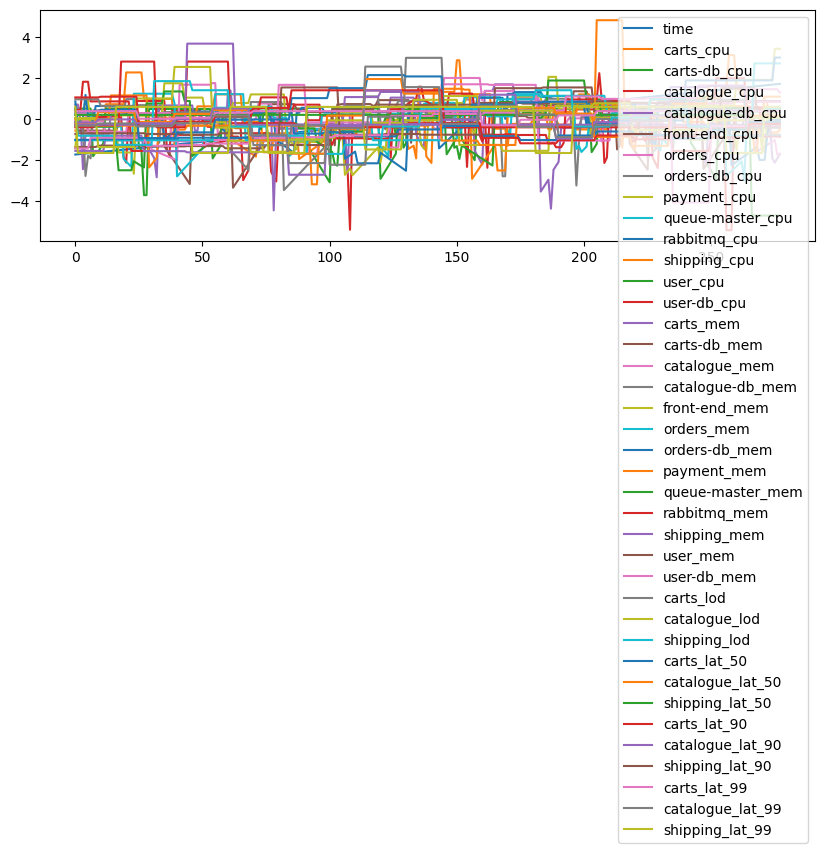

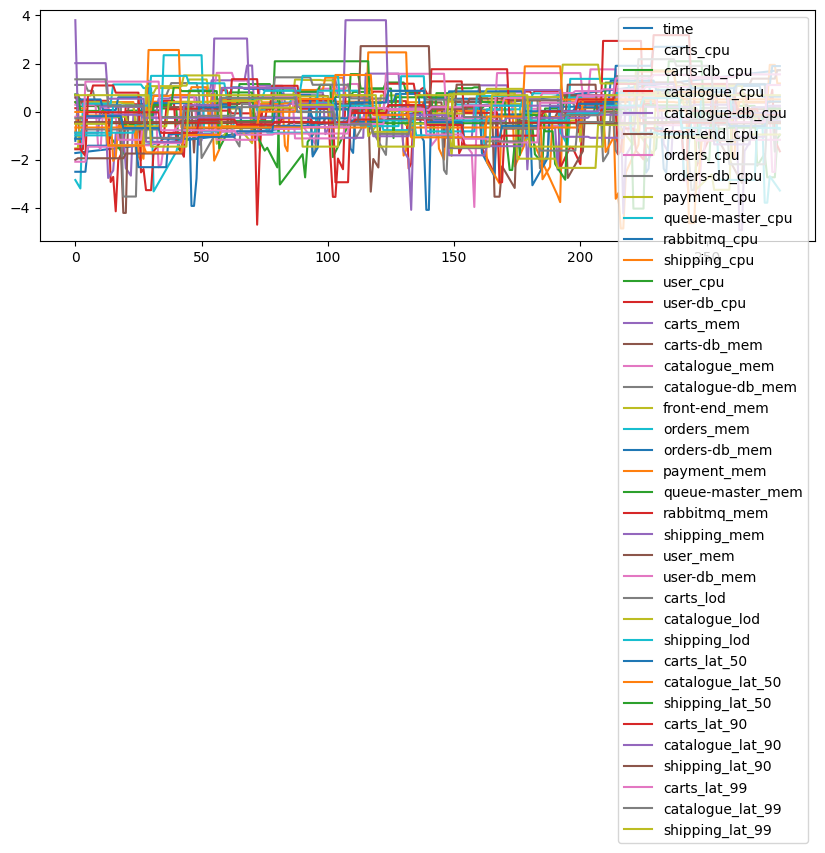

In [5]:
normal_df = pd.read_csv(RCD_DATA_PATH / "carts-cpu" / "2" / "normal.csv")
normal_df.apply(zscore).plot(figsize=(10, 3))
anomalous_df = pd.read_csv(RCD_DATA_PATH / "carts-cpu" / "2" / "anomalous.csv")
anomalous_df.apply(zscore).plot(figsize=(10, 3))

In [6]:
import sys
sys.path.append("../../rcd")

import rcd

In [7]:
import rcd
import utils as u

In [8]:
normal_df, anomalous_df = u.preprocess(normal_df, anomalous_df, 90)

results = defaultdict(int)
for i in range(100):
    result = rcd.top_k_rc(normal_df, anomalous_df, k=5, bins=rcd.BINS, localized=True)
    for m in result['root_cause']:
        results[m] += 1
results

defaultdict(int,
            {'carts_lat_90': 35,
             'carts-db_mem': 37,
             'user-db_mem': 34,
             'carts_lod': 30,
             'front-end_mem': 34,
             'carts_cpu': 30})

In [9]:
SOCKSHOP_DATASET_ID = "9n6mf"
TRAINTICKET_DATASET_ID = "m9dgg"

from meltria.priorknowledge.priorknowledge import SockShopKnowledge

sockshop_pk = SockShopKnowledge(
    target_metric_types={
        "containers": True,
        "services": True,
        "middlewares": True,
        "nodes": False,
    },
    mappings={"nodes-containers": {}},
)

In [10]:
from eval.tsdr import load_tsdr_by_chaos

dataset_by_chaos = load_tsdr_by_chaos(
    SOCKSHOP_DATASET_ID, {
        "services": True,
        "containers": True,
        "middlewares": False,
        "nodes": False,
    },
    revert_normalized_time_series=True,
    tsdr_options={
        "enable_unireducer": True,
        "enable_multireducer": True,
        "step1_method_name": "residual_integral",
        "step1_residual_integral_threshold": 20,
        "step1_residual_integral_change_start_point": False,
        "step1_residual_integral_change_start_point_n_sigma": 3,
        "step2_dbscan_min_pts": 1,
        "step2_dbscan_dist_type": "pearsonr",  # 'pearsonr' or 'sbd'
        "step2_dbscan_algorithm": "dbscan",  # 'dbscan' or 'hdbscan'
        "step2_clustering_series_type": "raw",  # 'raw', 'anomaly_score' or 'binary_anomaly_score'
        "step2_clustering_choice_method": "medoid",  # 'medoid' or 'maxsum'
    },
    use_manually_selected_metrics=True,
) 

In [11]:
record, data_df_by_metric_type = dataset_by_chaos[("pod-network-latency", "carts")][0]
dataset = pd.concat([
    data_df_by_metric_type["containers"][-1].iloc[100:180,:],
    data_df_by_metric_type["services"][-1].iloc[100:180, :],
], axis=1)
dataset.shape

(80, 66)

In [12]:
def _scale_down_mem(df):
    def update_mem(x):
        if '_memory_' not in x.name:
            return x
        x /= 1e6
        x = x.astype(int)
        return x

    return df.apply(update_mem)


_remove_last_seen = lambda df: df.loc[:, ~df.columns.str.endswith('last_seen')]

dataset = _remove_last_seen(dataset).apply(zscore).dropna(how="any", axis=1)
normal_df = dataset[dataset.index < 160]
anomalous_df = dataset[dataset.index >= 160]


df = u.add_fnode(normal_df, anomalous_df)
n_df = df[df[u.F_NODE] == '0'].drop(columns=[u.F_NODE])
a_df = df[df[u.F_NODE] == '1'].drop(columns=[u.F_NODE])

In [14]:
from threadpoolctl import threadpool_limits

N_ITERS = 10

results = defaultdict(int)
rcd.LOCAL_ALPHA = 0.01
for i in range(N_ITERS):
    with threadpool_limits(limits=1):
        result = rcd.rca_with_rcd(n_df, a_df, bins=5, localized=True)
    for k in {1, 3, 5, 10}:
        for m in result['root_cause'][:k]:
            results[(k, m)] += 1
    print(f"iteration={i}, time={round(result['time'],2)}, causes={len(result['root_cause'])}, {','.join(result['root_cause'])}")
sorted([(key, n/N_ITERS) for (key, n) in results.items()], key=lambda x: x[1], reverse=True)

iteration=0, time=0.55, causes=3, c-payment_cpu_system_seconds_total,s-orders_throughput,s-user_throughput
iteration=1, time=0.32, causes=3, c-catalogue-db_cpu_system_seconds_total,c-front-end_network_receive_packets_total,s-front-end_throughput
iteration=2, time=0.27, causes=3, c-front-end_network_receive_packets_total,s-orders_throughput,s-user_latency
iteration=3, time=0.27, causes=3, s-carts_throughput,s-catalogue_latency,c-carts-db_fs_writes_total
iteration=4, time=0.27, causes=3, c-carts-db_fs_writes_bytes_total,s-user_throughput,c-orders_network_transmit_bytes_total
iteration=5, time=0.27, causes=2, s-carts_throughput,c-user_cpu_usage_seconds_total
iteration=6, time=0.25, causes=3, c-user_network_transmit_bytes_total,s-catalogue_throughput,s-user_throughput
iteration=7, time=0.27, causes=3, c-catalogue_cpu_user_seconds_total,s-user_throughput,c-catalogue-db_network_receive_bytes_total
iteration=8, time=0.27, causes=3, s-catalogue_throughput,s-orders_throughput,c-catalogue-db_cpu

[((10, 's-catalogue_throughput'), 0.4),
 ((3, 's-catalogue_throughput'), 0.4),
 ((5, 's-catalogue_throughput'), 0.4),
 ((10, 's-orders_throughput'), 0.38),
 ((3, 's-orders_throughput'), 0.38),
 ((5, 's-orders_throughput'), 0.38),
 ((10, 's-carts_throughput'), 0.32),
 ((3, 's-carts_throughput'), 0.32),
 ((5, 's-carts_throughput'), 0.32),
 ((10, 's-user_throughput'), 0.24),
 ((3, 's-user_throughput'), 0.24),
 ((5, 's-user_throughput'), 0.24),
 ((1, 's-catalogue_throughput'), 0.18),
 ((1, 's-carts_throughput'), 0.16),
 ((1, 's-orders_throughput'), 0.12),
 ((10, 'c-catalogue_cpu_user_seconds_total'), 0.1),
 ((5, 'c-catalogue_cpu_user_seconds_total'), 0.1),
 ((10, 'c-carts-db_cpu_usage_seconds_total'), 0.1),
 ((3, 'c-carts-db_cpu_usage_seconds_total'), 0.1),
 ((5, 'c-carts-db_cpu_usage_seconds_total'), 0.1),
 ((10, 'c-catalogue-db_network_receive_bytes_total'), 0.08),
 ((3, 'c-catalogue_cpu_user_seconds_total'), 0.08),
 ((3, 'c-catalogue-db_network_receive_bytes_total'), 0.08),
 ((5, 'c-cat